In [1]:
import numpy as np
import math
from sklearn import preprocessing
from scipy.stats import skew
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [72]:
#Reading the data

train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

In [73]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'log(price + 1)'}>]], dtype=object)

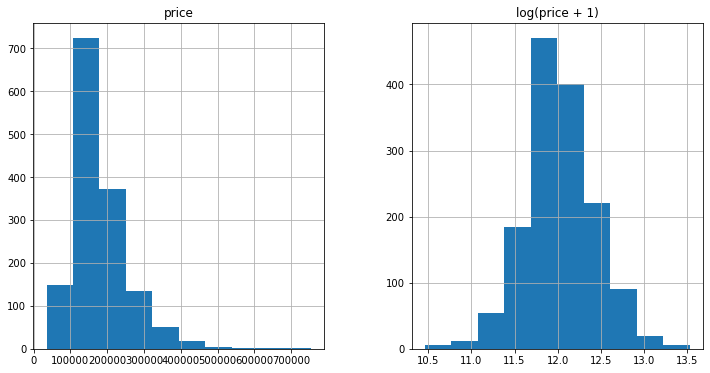

In [74]:
# We can see the values are skewed and with log(feature) we can bring to bell curve shape

plt.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [76]:

def feature_scaling():

    all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                          test.loc[:,'MSSubClass':'SaleCondition']))

    numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

    skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
    skewed_feats = skewed_feats[skewed_feats > 0.75]
    skewed_feats = skewed_feats.index

    all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
    all_data = pd.get_dummies(all_data)
    all_data = all_data.fillna(all_data.mean())
    
    
    return all_data

all_data = feature_scaling()


In [95]:

#data transformation
X_tr = np.array(all_data[:train.shape[0]])
X_test = np.array(all_data[train.shape[0]:])
y_tr = np.array(train.SalePrice)


#normalize the train data
normalize = preprocessing.Normalizer()
x_train_scaled = normalize.fit_transform(X_tr)
df_train = pd.DataFrame(x_train_scaled,columns = all_data.columns)


def remove_correlated_vars(df):
    
    cols = df.columns
    mat = df.corr()
    to_remove = set()

    for i in cols:
        for j in cols:
            if(i == j):
                continue
            else:
                if(abs(mat.loc[i][j]) > 0.75):
                    to_remove.add(j)
                    
    return list(to_remove)

#remove correlated features as linear regression is prone to correlated features
to_remove = remove_correlated_vars(df)

df_train = df_train.drop(to_remove,axis=1)


#Replicating same thing for test
#Note: we are using transform method not fit_transform because the mean and std computed from train will be applied here
x_test_scaled = normalize.transform(X_test)
df_test = pd.DataFrame(x_test_scaled,columns=all_data.columns)
df_test = df_test.drop(to_remove,axis=1)

#split the data for train and validation
X_train,X_val,y_train,y_val = train_test_split(df_train,y_tr,test_size=0.2,random_state=42)


In [151]:
ridge = Ridge(alpha=1,normalize=True,max_iter=2000)

#build a model
ridge.fit(X_train,y_train)

#test the validation data
print('----Validation Accuracy----\n')
print(ridge.score(X_val,y_val))

coef = ridge.coef_
#check how many coef were zeroed out
print("\n Ridge picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables\n")

#make prediction on test dataset
print('---Making Prediction------\n')
print(ridge.predict(df_test))

----Validation Accuracy----

0.8122898364033044

 Ridge picked 207 variables and eliminated the other 2 variables

---Making Prediction------

[127145.79335799 159024.14935219 185462.87508166 ... 165303.09564776
 130440.91219844 207093.37305393]


In [147]:
lasso = Lasso(alpha=1,normalize=True,max_iter=2000)

#build a model
lasso.fit(X_train,y_train)

#check the score for val dataset
print('----Validation Accuracy----\n')
print(lasso.score(X_val,y_val))

#get the coef values
coef = lasso.coef_

#check how many were zeroed out
print("\n Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables\n")


#make prediction
print('---Making Prediction------\n')
print(lasso.predict(df_test))

----Validation Accuracy----

0.8636906273149175

 Lasso picked 188 variables and eliminated the other 21 variables

---Making Prediction------

[127650.03214733 154875.73789812 182605.12532235 ... 166175.31728438
 115647.26495193 200365.72743257]


In [156]:

class LassoRegression:
    
    
    def __init__(self,max_iter=100,alpha=1,lr=0.5):
        
        self.iterations = max_iter
        self.alpha = alpha
        self.lr = lr
        
        
    def fit(self,X,y):
        
        self.n,self.m = X.shape
        self.W =  np.random.randn(self.m)/np.sqrt(self.m)
        self.X = X
        self.y = y
        self.losses = []
        self.b = 0
        
        #print(self.X)
        for i in range(self.iterations):
            self.update_weights()
    
    
        self.zero_coeff()
            
    def update_weights(self):
                
        y_pred = self.predict(self.X)
          
        # calculate gradients  
          
        dW = np.zeros(self.m)
          
        for j in range(self.m) :
              
            x_dot_y = ( self.X[:, j] ).dot( self.y - y_pred ) 
            
            #Why this condition, what happens when Self.w[j] == 0?
            if(self.W[j] == 0):
                continue
                
            if self.W[j] > 0 :
                dW[j] = (- 2 * x_dot_y + self.alpha ) / self.n
          
            else :
                dW[j] = (- 2 * x_dot_y - self.alpha ) / self.n
        
        #update bias
        db = - 2 * np.sum( self.y - y_pred ) / self.n
        self.b = self.b - self.lr * db
        
        # update weights
        self.W = self.W - self.lr * dW
        
        #append loss
        self.losses.append(self.loss(y_pred))
            
    def predict(self,X):
        
        return X.dot(self.W) + self.b
    
    def loss(self,y_pred):
        
        return np.linalg.norm(self.y - y_pred,ord=2)+ self.alpha * np.linalg.norm(self.W,ord=1)
    
    def score(self,X,y):
        
        y_pred = self.predict(X)
        MSE = np.mean((y_pred-y)**2)/(np.std(y)**2)
        Rsq = 1-MSE
        return round(Rsq,2)
    
    def zero_coeff(self):
        
        for j in range(len(self.W)):
            if(abs(int(self.W[j])) == 0):
                self.W[j] = 0

Accuracy Val  -0.01
Lasso picked 78 variables and eliminated the other 131 variables


Text(0, 0.5, 'Loss')

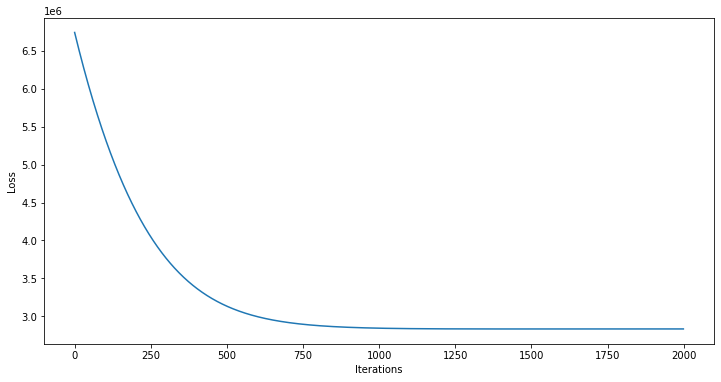

In [157]:
#model initialization
lasso = LassoRegression(max_iter=2000,alpha=1.5,lr=0.001)

#build a model
lasso.fit(np.array(X_train),np.array(y_train))

#get the score
print('Accuracy Val ',lasso.score(np.array(X_val),np.array(y_val)))

#check how much coeff has been zeroed out
coef = lasso.W
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

#plot the loss
plt.plot(range(lasso.iterations),lasso.losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Tried Hard but not able to improve the Accuracy

**I know the accuracy is terrible, potential problems can be**

- computing the gradients can be a culprit can you think why if self.w[j] > 0 condition in lasso? 
- weights are exploding so there will be an additional constraint of keeping abs(weights) <= constant
- hyper parameter tunning needs to be revisited
- Unnecessarily many coeff has been zeroed out so less information is in place for prediction

**Take away**
- How to perform feature selection and transformation, everytime is not about normalizing / standardizing the data 
- How to figure out where is the problem and resolve on your own. Try not to normalize the data and run my code with unscaled data. It will be nightmare to see the loss values
- How to write Machine learning code in object-oriented manner

# Resources

- GeeksforGeeks - https://www.geeksforgeeks.org/implementation-of-lasso-regression-from-scratch-using-python/
- Kaggle dataset https://www.kaggle.com/c/house-prices-advanced-regression-techniques